# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import re

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

titanic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")

ValueError: mount failed

# Data Cleaning

In [ ]:
# Age: Fill missing values with mean
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median()).round(1)

# Embarked: fill missing values with mode
titanic['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode()[0])

# PassengerId, Ticket, Cabin: drop
titanic = titanic.drop(columns=['PassengerId','Ticket','Cabin'])

# Feature Engineering

In [ ]:
# Age: Standardize
scaler = StandardScaler()
titanic[['Age']] = scaler.fit_transform(titanic[['Age']])

# Sex: One-hot encode
titanic = pd.get_dummies(titanic, columns=['Sex'], drop_first=True)

# Fare: Log base 10 transformation
titanic['Fare_log10'] = np.log10(titanic['Fare'] + 1)

# Embarked: One-hot encode
titanic = pd.get_dummies(titanic, columns=['Embarked'], drop_first=True)

# FamilySize: Create variable to sum SibSp and Parch
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1

# Alone: Create variable based on FamilySize
titanic['Alone'] = (titanic['FamilySize'] == 1).astype(int)

# Name --> Title: extract title from name
titanic['Title'] = titanic['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

titanic['Title'] = titanic['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
titanic['Title'] = titanic['Title'].apply(lambda x: x if x in common_titles else 'Rare')

# One-hot encode
title_dummies = pd.get_dummies(titanic['Title'], prefix='Title')
title_dummies = title_dummies.drop(columns=['Title_Rare'])
titanic = pd.concat([titanic.drop(columns=['Title']), title_dummies], axis=1)

In [ ]:
# Convert boolean variables to numeric
for col in titanic.columns:
    if titanic[col].dtype == 'bool':
        titanic[col] = titanic[col].astype(int)

# Training Setup - Bernoulli

In [ ]:
# Independent and dependent variables
x = titanic[['Sex_male', 'Alone', 'Title_Mr', 'Title_Mrs', 'Title_Miss', 'Title_Master', 'Embarked_Q', 'Embarked_S']] #binary variables
y = titanic['Survived']

# Splitting the dataset: 70% train, 15% test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y)

# Naive Bayes - BernoulliNB

Training Accuracy: 0.799
Testing Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           0      0.840     0.794     0.816       165
           1      0.696     0.757     0.726       103

    accuracy                          0.780       268
   macro avg      0.768     0.776     0.771       268
weighted avg      0.785     0.780     0.781       268



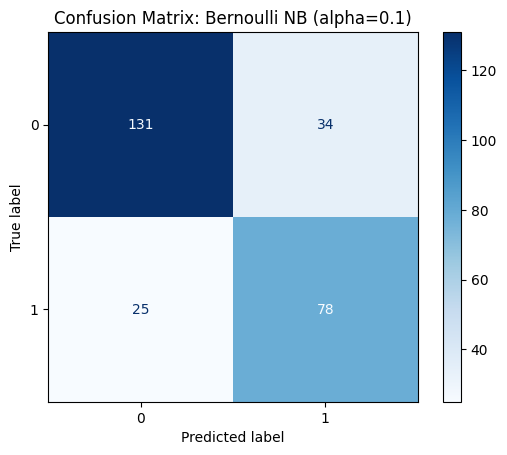

In [ ]:
bernoulli = BernoulliNB(alpha=0.1)
bernoulli.fit(x_train, y_train)
y_pred_bernoulli = bernoulli.predict(x_test)

print("Training Accuracy:",round(bernoulli.score(x_train, y_train),3))
print("Testing Accuracy:",round(bernoulli.score(x_test, y_test),3))
print("\nClassification Report:\n",classification_report(y_test, y_pred_bernoulli, digits=3, zero_division=0))

cm = confusion_matrix(y_test, y_pred_bernoulli)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Bernoulli NB (alpha=0.1)")
plt.show()

# Training Setup - Regression

In [ ]:
# Independent variables (dependent variable stays same)
x = titanic[['Age', 'Sex_male', 'FamilySize', 'Alone', 'Fare_log10',
             'Title_Mr', 'Title_Mrs', 'Title_Miss', 'Title_Master', 'Embarked_Q', 'Embarked_S']]

# Splitting the dataset: 70% train, 30% test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y)

# Linear Regression

Linear Regression Accuracy: 0.832089552238806

Classification Report:
               precision    recall  f1-score   support

           0      0.853     0.879     0.866       165
           1      0.796     0.757     0.776       103

    accuracy                          0.832       268
   macro avg      0.824     0.818     0.821       268
weighted avg      0.831     0.832     0.831       268



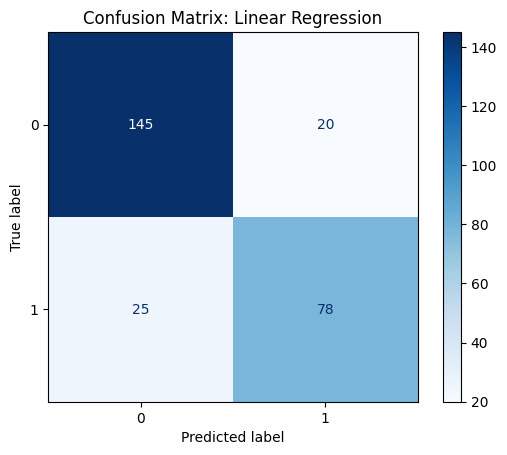

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_lr = (lr.predict(x_test) >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_lr)

print("Linear Regression Accuracy:", accuracy)
print("\nClassification Report:\n",classification_report(y_test, y_pred_lr, digits=3, zero_division=0))

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Linear Regression")
plt.show()

In [ ]:
#Testing alpha values
alphas = np.logspace(-3, 2, 30)
results_ridge = []
results_lasso = []

for a in alphas:
    ridge = Ridge(alpha=a).fit(x_train, y_train)
    y_pred_ridge = (ridge.predict(x_test) >= 0.5).astype(int)
    accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
    results_ridge.append({'Alpha': a, 'Accuracy': accuracy_ridge})

    lasso = Lasso(alpha=a).fit(x_train, y_train)
    y_pred_lasso = (lasso.predict(x_test) >= 0.5).astype(int)
    accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
    results_lasso.append({'Alpha': a, 'Accuracy': accuracy_lasso})

ridge_results = pd.DataFrame(results_ridge)
lasso_results = pd.DataFrame(results_lasso)

best_alpha_ridge = pd.DataFrame(results_ridge).loc[ridge_results['Accuracy'].idxmax()]
best_alpha_lasso = pd.DataFrame(results_lasso).loc[lasso_results['Accuracy'].idxmax()]

print("Ridge: Best Alpha:", best_alpha_ridge['Alpha'],"Max Accuracy:", best_alpha_ridge['Accuracy'])
print("Lasso: Best Alpha:", best_alpha_lasso['Alpha'],"Max Accuracy:", best_alpha_lasso['Accuracy'])

Ridge: Best Alpha: 0.11721022975334805 Max Accuracy: 0.835820895522388
Lasso: Best Alpha: 0.001 Max Accuracy: 0.835820895522388


Ridge Regression Accuracy: 0.835820895522388

Classification Report:
               precision    recall  f1-score   support

           0      0.854     0.885     0.869       165
           1      0.804     0.757     0.780       103

    accuracy                          0.836       268
   macro avg      0.829     0.821     0.825       268
weighted avg      0.835     0.836     0.835       268



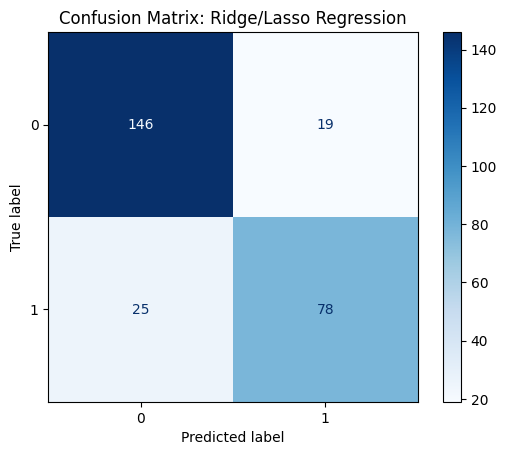

In [ ]:
#Ridge Regression

ridge = Ridge(alpha=0.12)
ridge.fit(x_train, y_train)
y_pred_ridge = (ridge.predict(x_test) >= 0.5).astype(int)

accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
print("Ridge Regression Accuracy:", accuracy_ridge)
print("\nClassification Report:\n",classification_report(y_test, y_pred_ridge, digits=3, zero_division=0))

cm = confusion_matrix(y_test, y_pred_ridge)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Ridge/Lasso Regression")
plt.show()

LASSO Regression Accuracy: 0.835820895522388

Classification Report:
               precision    recall  f1-score   support

           0      0.854     0.885     0.869       165
           1      0.804     0.757     0.780       103

    accuracy                          0.836       268
   macro avg      0.829     0.821     0.825       268
weighted avg      0.835     0.836     0.835       268



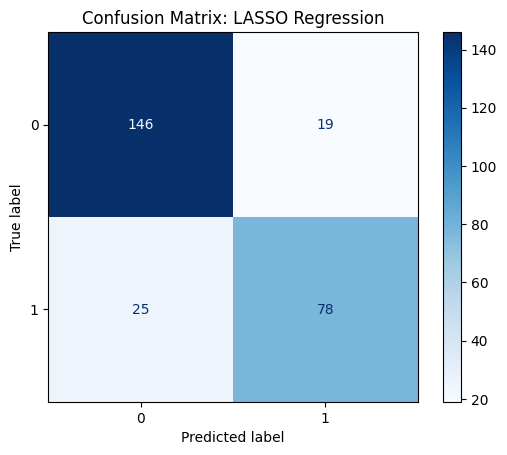

In [ ]:
#LASSO Regression

lasso = Lasso(alpha=0.001)
lasso.fit(x_train, y_train)
y_pred_lasso = (lasso.predict(x_test) >= 0.5).astype(int)

accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
print("LASSO Regression Accuracy:", accuracy_lasso)
print("\nClassification Report:\n",classification_report(y_test, y_pred_lasso, digits=3, zero_division=0))

cm = confusion_matrix(y_test, y_pred_lasso)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: LASSO Regression")
plt.show()

# Model Evaluation

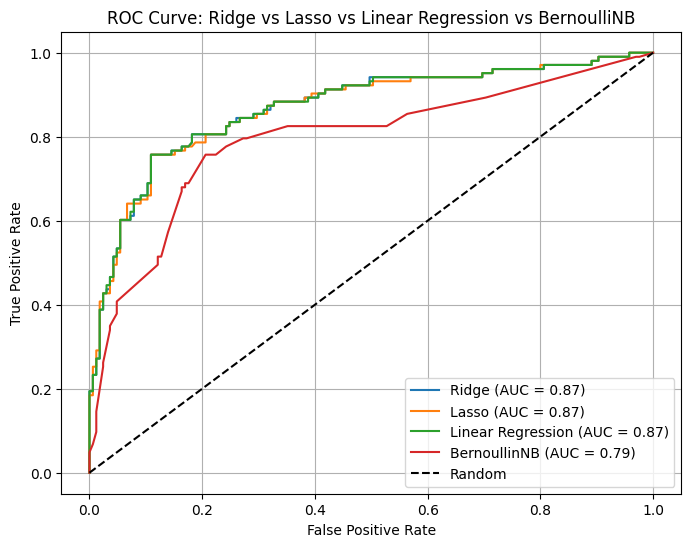

In [ ]:
# Linear Regression
y_scores_lr = lr.predict(x_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
auc_lr = roc_auc_score(y_test, y_scores_lr)

# Ridge
y_scores_ridge = ridge.predict(x_test)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_scores_ridge)
auc_ridge = roc_auc_score(y_test, y_scores_ridge)

# Lasso
y_scores_lasso = lasso.predict(x_test)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_scores_lasso)
auc_lasso = roc_auc_score(y_test, y_scores_lasso)

# BernoulliNB
bnb = BernoulliNB().fit(x_train, y_train)
y_scores_bnb = bnb.predict_proba(x_test)[:, 1]  # probability for class 1
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_scores_bnb)
auc_bnb = roc_auc_score(y_test, y_scores_bnb)

plt.figure(figsize=(8,6))
plt.plot(fpr_ridge, tpr_ridge, label=f'Ridge (AUC = {auc_ridge:.2f})')
plt.plot(fpr_lasso, tpr_lasso, label=f'Lasso (AUC = {auc_lasso:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Linear Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_bnb, tpr_bnb, label=f'BernoullinNB (AUC = {auc_bnb:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Ridge vs Lasso vs Linear Regression vs BernoulliNB')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()